# Algorithm Classification for Comment Generation RNN
Identifies the algorithm used in a given snippet to provide a helpful descriptive comment of what is being performed.

**Maintenance**: Retrain the model with any required algorithms you want it to be able to recognise.

In [219]:
import numpy as np
import os
import re
import time
import copy
import json
import random
import matplotlib.pyplot as plt

In [220]:
def stringToMatrixForPrediction(codeBlock,noTokens):
    """Represents a string of Python code as a one-hot matrix so that it can be passed into the algorithm classifier subroutine."""
    
    blockMatrix = np.ones((noTokens,1)) #Will store a set of one-hot vectors, one for each character in the current block of code, stacked horizontally. All 1s will be the start token
    for char in codeBlock: #each character in current block
        featureMatrix = np.zeros((noTokens,1)) #Create one hot vector for this character, starting with all cold
        try:
            featureMatrix[ALPHABET.index(char)] = 1 #Make the correct one hot
        except ValueError: #Unknown char so use the unk token
            featureMatrix[noTokens-1] = 1

        blockMatrix = np.hstack((blockMatrix,featureMatrix)) #Stack next to other vectors to build matrix of one-hot for the line
        
    return blockMatrix #return code block's onehot representation to caller

def loadDataset(storeResult,noTokens,path):
    """Converts the training input file into matrices of One-Hot vectors"""
    
    with open(path,"r") as f:
        eachAlgo = f.read().split("\n\n") #Double newline separated
        for codeText in eachAlgo:

            blockMatrix = stringToMatrixForPrediction(codeText,noTokens)

            featureMatrix = np.zeros((noTokens,1)) #Create one hot vector for this character
            featureMatrix[noTokens-2] = 1 #EOL token
            blockMatrix = np.hstack((blockMatrix,featureMatrix)) #Stack next to other vectors
            storeResult.append(blockMatrix) #Save with the other algorithms

def oneHotMatrixToString(oneHotMatrix):
    """Converts a one-hot matrix representing one algorithm back into the algorithm's code. Reverse of the above 2 functions."""
    indices = np.matrix(range(oneHotMatrix.shape[0])).reshape(oneHotMatrix.shape[0],1) #Creates a Tx1 vector where T is the number of one-hot tokens. 
    res = oneHotMatrix.T * indices #Use matrix multiplication to extract the index of the one that is hot inside the one hot vectors
    s = "" #acc to reconstruct string
    for index in res[1:,0]: #Skip first token which is just a start token then loop over all tokens in line of code
        try:
            s += ALPHABET[int(index[0,0])] #Convert back to character and save ready to return
        except IndexError: #If the token was unknown and so char not in string, IndexError as UNK is the last token.
            s += "{UNK}" #Report this
    return s


In [221]:
ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz1234567890!'Â£$%^&*()[]-=+_;:@~#,<\n.>/?\\|\" {}`\t" #Each is a one hot token
N_TOKENS = len(ALPHABET)+2
#Extract train data to produce character wise one hot token vectors
train = []
loadDataset(train,N_TOKENS,"AlgorithmIdentificationComments.py")

In [222]:
#Display one line of code for example purposes. This checks that we can correctly convert both ways between one hot and string representation.
EXAMPLE = 2
print(oneHotMatrixToString(train[EXAMPLE]))

def quicksort(myList,start,end):
	if (start < end):
		pivotVal = myList[end]
		i = start - 1
		for j in range(start,end+1):
			if myList[j] <= pivotVal:
				i += 1
				myList[i],myList[j] = myList[j],myList[i]          
		split = i
		quicksort(myList,start,split-1)
		quicksort(myList,split+1,end)
		return myList{UNK}


In [223]:
#Activation functions and their derivatives

def softmax(z):
  """Softmax function - acts on vectors to normalise total sum to be out of 1, to create probabilities"""
  t = np.exp(z)
  return t/np.sum(t)

def tanh(matrix):
  """Hyperbolic tangent"""
  matrix = matrix.astype(np.float64)
  return (np.exp(matrix) - np.exp(-matrix))/(np.exp(matrix)+np.exp(-matrix))


def tanh_prime(matrix):
  """Derivative of hyperbolic tan function"""
  return 1-np.square(tanh(matrix))


In [224]:
def trainRNNClassifierModel(algorithmsList,noOfAlgorithms,dictSize,alpha,hiddenLayerNodes,numIter,g_1=tanh,g_1_prime=tanh_prime):
  """Train the RNN model for numIter iterations, with first layer activation function g_1"""
  
  #Say that the no of hidden layer nodes is 100 and number of possible tokens is 10000 just for an example. This yields the dimensions for each matrix as specified in comments
  #(Assumes softmax as g_2)
  
  m = len(algorithmsList) #Number of training examples

  #Xavier initialisation
  W_a = np.random.standard_normal((hiddenLayerNodes,hiddenLayerNodes+dictSize)) * np.sqrt(1/len(ALPHABET))# First layer weights, example dimensions 100*10100
  W_y = np.random.standard_normal((noOfAlgorithms,hiddenLayerNodes)) * np.sqrt(1/len(ALPHABET)) #Second layer weights, example dimensions 10000*100 
  b_a = np.random.standard_normal((hiddenLayerNodes,1)) * np.sqrt(1/len(ALPHABET)) #First layer biases, example dimensions 100*1 
  b_y = np.random.standard_normal((noOfAlgorithms,1)) * np.sqrt(1/len(ALPHABET)) #Second layer biases, example dimensions 10000*1
  Js = [] #Store cost functions over each iteration for debug

  for iter in range(numIter): #Train for numIter iterations
    
    print(iter) #Debug print to check speed of training
    
    J = 0 #Initialise cost function for this iteration
    
    for label,trainingExample in enumerate(algorithmsList): #Train on every algorithm on each iteration
      codeLength = trainingExample.shape[1] #Length of algorithm code we are currently training on.

      z_1 = [np.zeros((hiddenLayerNodes,1)) for i in range(codeLength)]  #logits on l1 before application of g_1 at each timestep 
      a = [np.zeros((hiddenLayerNodes,1)) for i in range(codeLength)] #Activations after application of g_1 at each timestep

      #Accumulator variables for the derivatives w.r.t the loss function of W_a,W_y,b_a,b_y for the backprop
      dW_a_acc = np.zeros(W_a.shape) 
      dW_y_acc = np.zeros(W_y.shape)
      db_a_acc = np.zeros(b_a.shape)
      db_y_acc = np.zeros(b_y.shape)
    
      for charIndex in range(0,codeLength-1): 
        #FORWARD PROPAGATION
        x_t = np.reshape(trainingExample[:,charIndex],(dictSize,1)) # Current character in the string (one hot), representing the input to this time step (dims 10000* 1)

        z_t_1 = np.matmul(W_a,np.vstack((a[charIndex-1],x_t))) + b_a # Logits for this layer before application of g_1 (dims 100*1)
        z_1[charIndex] = z_t_1 #Save this value in an array because we will need it later for backprop

        a[charIndex] = g_1(z_t_1) #Activations after application of g_1 at this timestep (dims 100*1), will be passed into next timestep. Overall in the input process we consolidate (encode) the input data in such a way that we will be able to make a good prediction afterwards
    
      #NOTE: Subtle difference compared to autocomplete model - only extract a softmax prediction after processing *all* of the input characters.
     # print(a[charIndex].shape)
      z_t_2 = np.matmul(W_y,a[charIndex]) + b_y #logits after hidden layer before application of g_2===softmax
      y_hat = softmax(z_t_2) #Prediction for this timestep (i.e. guessed next character), applying softmax to get probabilities
    #  print(y_hat)

      y = np.zeros((noOfAlgorithms,1)) #groundTruthLabel
      y[label,:] = 1
      L = -np.sum((y) * np.log(y_hat)) #Loss for this code snippet

      #BACKPROPAGATION - This time we only do backprop through time after processing the whole snippet.
      dZ_2 = y_hat - (y) #Derivative of loss function w.r.t second layer Z values (10000*1)
      dW_y = np.matmul(dZ_2,a[charIndex].T) #Derivative of loss function w.r.t second layer weight values (10000*100)
      db_y = dZ_2 #Derivative of loss function w.r.t second layer bias values (10000*1)
      da_1 = np.matmul(W_y.T,dZ_2) #Derivative of loss function w.r.t first layer activations (100*1)
      dZ_1 = np.multiply(da_1,g_1_prime(z_t_1)) #Derivative of loss function w.r.t first layer Z values (100*1)
      dW_a = np.matmul(dZ_1,np.vstack((a[charIndex-1],x_t)).T) # Derivative of loss function w.r.t first layer weights (100*10100)
      db_a = dZ_1 #Derivative of loss function w.r.t first layer biases (100*1)

      #Accumulate total derivatives
      dW_a_acc += dW_a 
      dW_y_acc += dW_y
      db_a_acc += db_a
      db_y_acc += db_y         
  
      #Backprop through time
      for backwardTime in range(charIndex-1-1,-1): #Iterate backwards over the previous timesteps (code characters) up to this point
          W_aa = W_a[:,hiddenLayerNodes] #The subsection of the layer 1 weights that multiply by the activations from the previous timestep (as opposed to x features from this timestep)(100,100)
          da_t_minus_one = np.matmul(W_aa,dZ_1) #Derivative of cost w.r.t previous layer activations (100*1)
        
          dZ_1 = np.multiply(da_t_minus_one,g_1_prime(z_1[backwardTime])) #Derivative of cost w.r.t. Z_1 values at some previous layer (100*1)
          x_this_t = np.reshape(trainingExample[:,backwardTime],(noOfAlgorithms,1)) #Input value x for (10000* 1)

    
          dW_a = np.matmul(dZ_1,np.vstack((a[backwardTime-1],x_t)).T)# Derivative of the loss function at the final layer w.r.t the weights at this layer (100*10100)
          db_a = dZ_1 #Derivative of the loss function at final layer w.r.t biases at this layers (100*1)

          #Save so we can use the overall cost derivatives to update the weights after this training example
          dW_a_acc += dW_a
          dW_y_acc += dW_y

      #Update weights based on derivatives - alpha is gradient descent learning rate parameter
      W_a = W_a - alpha*dW_a_acc 
      W_y = W_y - alpha*dW_y_acc
      b_a = b_a - alpha*db_a_acc
      b_y = b_y - alpha*db_y_acc  

      J += L #Cost is loss over all training examples
    
    J = J/m #Average cost per training example
    Js.append(J) #Save so we can plot later for debugging

  plt.plot(Js) #debug to check cost is monotonically decreasing
  plt.title("Shallow RNN Cost Function with iterations of gradient descent")
  return W_a,W_y,b_a,b_y #Trained weights


Streaming output truncated to the last 5000 lines.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
2

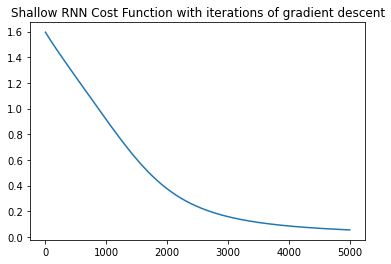

In [225]:
LEARNING_RATE = 0.0005 #Gradient descent alpha
HIDDEN_LAYER_NODES = 50 #Network architecture
NUM_ITER = 5000 #Training iterations
NO_ALGORITHMS = 5

#Time the training process
start = time.time()
trainedW_a,trainedW_y,trainedb_a,trainedb_y = trainRNNClassifierModel(train,NO_ALGORITHMS,N_TOKENS,LEARNING_RATE,HIDDEN_LAYER_NODES,NUM_ITER)
end = time.time()
print("Done in " + str(end-start) + " secs") #report how long the training took

In [226]:
#Display trained weights and biases
print(trainedb_a)
print(trainedW_a)
print(trainedb_y)
print(trainedW_y)

[[-0.10131921]
 [-0.02132363]
 [-0.03041457]
 [ 0.00166798]
 [-0.10367333]
 [ 0.04620822]
 [ 0.01641107]
 [ 0.03171044]
 [-0.09698621]
 [ 0.08967468]
 [ 0.04797042]
 [-0.09827135]
 [-0.15909743]
 [-0.1225254 ]
 [-0.13178912]
 [-0.16342781]
 [ 0.11406862]
 [ 0.01316925]
 [-0.0148989 ]
 [-0.11926596]
 [ 0.01553015]
 [-0.00888958]
 [ 0.17292537]
 [ 0.05302696]
 [-0.06723728]
 [ 0.06381725]
 [-0.03553599]
 [-0.00528468]
 [ 0.00518222]
 [-0.06799117]
 [ 0.13634296]
 [ 0.06047567]
 [-0.12744515]
 [ 0.03043234]
 [-0.13725896]
 [-0.13180903]
 [ 0.269605  ]
 [ 0.0964615 ]
 [-0.11234214]
 [ 0.15859804]
 [ 0.03179589]
 [ 0.02417548]
 [ 0.0612577 ]
 [-0.14546777]
 [-0.09165698]
 [-0.17487431]
 [-0.26410388]
 [-0.00313377]
 [-0.0630392 ]
 [ 0.0008484 ]]
[[ 0.14730126 -0.05348426 -0.04838639 ...  0.10520339  0.03971054
   0.04967326]
 [-0.08783953  0.08202733 -0.17023767 ... -0.19463777 -0.08241059
  -0.00660153]
 [ 0.04055825  0.01893331  0.08243181 ... -0.07960759 -0.03624068
  -0.00729162]
 ...
 

In [227]:
#Saves the weights and biases to a binary file so they can be shipped with the solution and imported therein.

SAVE_PATH = "C:\\Users\\marks\\Documents\\ML"

with open(os.path.join(SAVE_PATH,"trainedW_aComment.npy"),"wb") as f:
  np.save(f,trainedW_a)
with open(os.path.join(SAVE_PATH,"trainedW_yComment.npy"),"wb") as f:
  np.save(f,trainedW_y)
with open(os.path.join(SAVE_PATH,"trainedb_yComment.npy"),"wb") as f:
  np.save(f,trainedb_y)
with open(os.path.join(SAVE_PATH,"trainedb_aComment.npy"),"wb") as f:
  np.save(f,trainedb_a)
print("saved")

saved


In [228]:
#These methods will be shipped in the final solution along with the weights 

ASSOCIATED_COMMENTS_LIST = ["Calculates the dot product of two vectors","Depth First Search Graph Traversal","Quicksort algorithm (Lomuto Scheme)","Bubble Sort algorithm","Binary Search algorithm"]
def getAlgorithmClassificationComment(inputCode,commentsList,W_a,W_y,b_a,b_y,noOfAlgorithms,dictSize,hiddenLayerNodes,g_1=tanh,g_1_prime=tanh_prime):
      """Identifies the algorithm whose code is represented by the one hot vector in the inputCode variable, using RNN with trained weights W_a,W_y,b_a,b_y"""

      codeLength = inputCode.shape[1] #Length of algorithm code we want a prediction for

      z_1 = [np.zeros((hiddenLayerNodes,1)) for i in range(codeLength)]  #logits on l1 before application of g_1 at each timestep 
      a = [np.zeros((hiddenLayerNodes,1)) for i in range(codeLength)] #Activations after application of g_1 at each timestep

      for charIndex in range(0,codeLength-1): 
        #FORWARD PROPAGATION
        x_t = np.reshape(inputCode[:,charIndex],(dictSize,1)) # Current character in the string (one hot), representing the input to this time step (dims 10000* 1)

        z_t_1 = np.matmul(W_a,np.vstack((a[charIndex-1],x_t))) + b_a # Logits for this layer before application of g_1 (dims 100*1)
        z_1[charIndex] = z_t_1 

        a[charIndex] = g_1(z_t_1) #Activations after application of g_1 at this timestep (dims 100*1), will be passed into next timestep. Overall in the input process we consolidate (encode) the input data in such a way that we will be able to make a good prediction afterwards
    
      z_t_2 = np.matmul(W_y,a[charIndex]) + b_y #logits after hidden layer before application of g_2===softmax
      y_hat = softmax(z_t_2) #Normalise probability estimates to be out of 1
      
      if (y_hat[np.argmax(z_t_2)] < 0.30): #Not confident enough to make a prediction (only 30%)
          return "Unrecognised algorithm"
      else:
        return commentsList[np.argmax(z_t_2)] # Confident enough so return result to caller ready to be put into the code.

for i in range(NO_ALGORITHMS):
    print(getAlgorithmClassificationComment(train[i],ASSOCIATED_COMMENTS_LIST,trainedW_a,trainedW_y,trainedb_a,trainedb_y,NO_ALGORITHMS,N_TOKENS,HIDDEN_LAYER_NODES))


Calculates the dot product of two vectors
Depth First Search Graph Traversal
Quicksort algorithm (Lomuto Scheme)
Bubble Sort algorithm
Binary Search algorithm


In [230]:
test = []
loadDataset(test,N_TOKENS,"algIdentificationTestSet.py")
correctAnswers =  ["Bubble Sort algorithm","Calculates the dot product of two vectors","Binary Search algorithm","Depth First Search Graph Traversal","Depth First Search Graph Traversal","Unrecognised algorithm"]
for i,alg in enumerate(test):
    print("Correct Answer: " + correctAnswers[i])
    print("Algorithm's guess: " + getAlgorithmClassificationComment(alg,ASSOCIATED_COMMENTS_LIST,trainedW_a,trainedW_y,trainedb_a,trainedb_y,NO_ALGORITHMS,N_TOKENS,HIDDEN_LAYER_NODES))
    print()

Correct Answer: Bubble Sort algorithm
Algorithm's guess: Bubble Sort algorithm

Correct Answer: Calculates the dot product of two vectors
Algorithm's guess: Calculates the dot product of two vectors

Correct Answer: Binary Search algorithm
Algorithm's guess: Binary Search algorithm

Correct Answer: Depth First Search Graph Traversal
Algorithm's guess: Bubble Sort algorithm

Correct Answer: Depth First Search Graph Traversal
Algorithm's guess: Depth First Search Graph Traversal

Correct Answer: Unrecognised algorithm
Algorithm's guess: Binary Search algorithm
